# Importing Relevant Libraries and Connecting to Google Drive
]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ReduceLROnPlateau
import pickle
from keras import backend as K

import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.optimizers.legacy import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
width=64
height=64
depth=3
image_size = 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/plantdetection/PlantVillage"
print (path)

/content/drive/MyDrive/plantdetection/PlantVillage


# Converting Images into arrays and resizing them

In [ ]:
def image_to_array(directory):
  img = cv2.imread(directory)
  if img is not None:
    img = cv2.resize(img, default_image_size)
    return img_to_array(img)
  else:
    return np.array([])

In [ ]:
img_list = []
img_label_list = []

try:
    list_of_dir = os.listdir(path)
    for direct in list_of_dir:
      image_file = os.listdir(path + "/" + direct)

      for imgs in image_file:
        img_path = (path + '/' + direct + '/' + imgs)
        if img_path.endswith('jpg') == True or img_path.endswith('JPG') == True:
          img_list.append(image_to_array(img_path))
          img_label_list.append(direct)

except Exception as e:
    print('error' + e)

# Converting the Labels to Bianry

In [ ]:
lb = LabelBinarizer()
img_label_list_binary = lb.fit_transform(img_label_list)
pickle.dump(lb,open('label_transform.pkl', 'wb'))
n_classes = len(lb.classes_)
print(lb.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


# Normalising and splitting the dataset

In [ ]:
img_list_array = np.array(img_list, dtype=np.float16) / 255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_list_array, img_label_list_binary, test_size=0.20, random_state=42)

# Data augmentation

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

Implentation of the VGG16 model

In [ ]:
inputShape = (height, width, depth)
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=inputShape))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=15, activation="softmax"))


# Compiling and fitting the model

In [ ]:

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
import keras


model.compile(loss="binary_crossentropy", optimizer=Adam(0.0001),metrics=["accuracy"])


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(
    aug.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 32,
    epochs=500, verbose=1
    )

Epoch 1/500


<ipython-input-21-e9ac74da7dfd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


516/516 [==============================] - 21s 40ms/step - loss: 0.2732 - accuracy: 0.2040 - val_loss: 0.1672 - val_accuracy: 0.5533
Epoch 2/500
516/516 [==============================] - 20s 39ms/step - loss: 0.2002 - accuracy: 0.3804 - val_loss: 0.1408 - val_accuracy: 0.6061
Epoch 3/500
516/516 [==============================] - 20s 40ms/step - loss: 0.1734 - accuracy: 0.4766 - val_loss: 0.1224 - val_accuracy: 0.6547
Epoch 4/500
516/516 [==============================] - 21s 40ms/step - loss: 0.1580 - accuracy: 0.5237 - val_loss: 0.1139 - val_accuracy: 0.6702
Epoch 5/500
516/516 [==============================] - 20s 39ms/step - loss: 0.1467 - accuracy: 0.5650 - val_loss: 0.1054 - val_accuracy: 0.7109
Epoch 6/500
516/516 [==============================] - 20s 39ms/step - loss: 0.1375 - accuracy: 0.5956 - val_loss: 0.0986 - val_accuracy: 0.7145
Epoch 7/500
516/516 [==============================] - 20s 39ms/step - loss: 0.1310 - accuracy: 0.6172 - val_loss: 0.0968 - val_accuracy: 0.73

# Evaluating the Model

In [ ]:
scores = model.evaluate(X_test, y_test)

130/130 [==============================] - 0s 3ms/step - loss: 0.0815 - accuracy: 0.8942


In [ ]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)


130/130 [==============================] - 0s 2ms/step
[[190   4   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 312   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0 178   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  32 174   0   1   3   1   0   0   0   0   0   0   0]
 [  0   0   0   1  29   0   0   0   0   0   0   0   0   0   2]
 [  0   0   1   1   0 410   3   1   0   0   0   7   3   0   1]
 [  0   0   5   0   0   0 186   0   0   2   0   2   1   0   2]
 [  1   1  22  14   0   1  27 273   1   6   1   0   0   0  18]
 [  0   0   0   0   0   0   2   0 191   3   0   2   0   0   4]
 [  0   0  18   1   0   1   0   0   1 331   0   0   0   0   1]
 [  0   0   0   1   0   0   1   1   0   0 203   2   0   0  97]
 [  0   1   1   0   0   0   5   1   0   4  10 194   0   0  88]
 [  0   1   0   0   0   5   0   0   1   0   3   2 644   0   0]
 [  0   0   0   0   0   0   1   0   1   4   1   0   0  61   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 317]]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       194
           1       0.98      1.00      0.99       313
           2       0.69      1.00      0.82       178
           3       0.91      0.82      0.86       211
           4       0.97      0.91      0.94        32
           5       0.98      0.96      0.97       427
           6       0.82      0.94      0.87       198
           7       0.99      0.75      0.85       365
           8       0.98      0.95      0.96       202
           9       0.95      0.94      0.94       353
          10       0.93      0.67      0.78       305
          11       0.93      0.64      0.76       304
          12       0.99      0.98      0.99       656
          13       1.00      0.81      0.90        75
          14       0.59      1.00      0.74       317

    accuracy                           0.89      4130
   macro avg       0.91      0.89      0.89      4130
weighted avg       0.92   

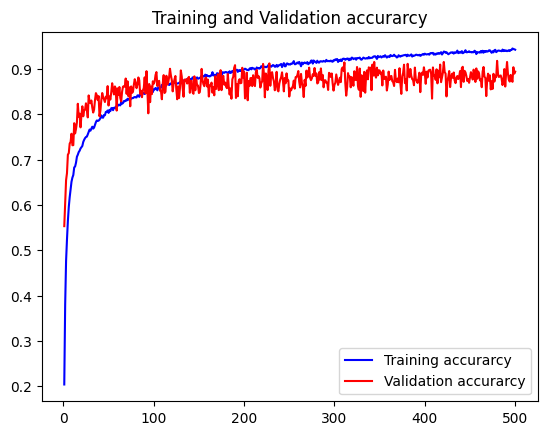

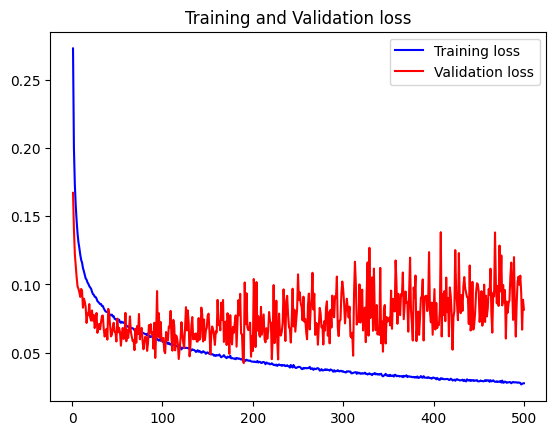

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Predictions of the Model on unseen Data

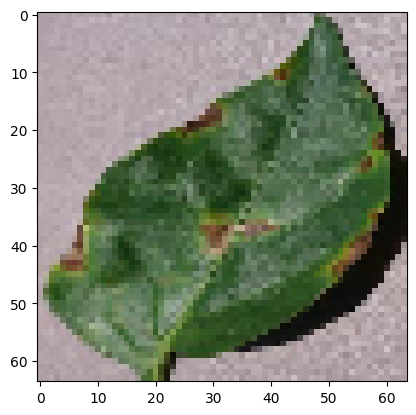

In [ ]:
imagepath = imread("/content/drive/MyDrive/plantdetection/024623ab-be81-4d99-a653-c3be1495ce8e___JR_B.Spot 8889.jpg")
image = imread("/content/drive/MyDrive/plantdetection/024623ab-be81-4d99-a653-c3be1495ce8e___JR_B.Spot 8889.jpg")
image = cv2.resize(image,(64,64))
imagepath = cv2.resize(imagepath,(64,64))
image = np.array(image/255)
image = image.reshape(-1,64,64,3)
plt.imshow(imagepath)

In [ ]:
classification_result = model.predict(image)
print(classification_result)

1/1 [==============================] - 0s 168ms/step
[[1.41367573e-09 9.99989271e-01 6.55901911e-15 1.45155349e-25
  3.76622504e-38 2.11280533e-31 2.16597879e-10 6.47041719e-17
  4.62176963e-15 1.07475025e-05 2.29722144e-37 1.40727524e-32
  1.20071197e-24 2.20504465e-33 1.17054306e-37]]


In [ ]:
print(lb.classes_[(classification_result.argmax())])

Pepper__bell___healthy


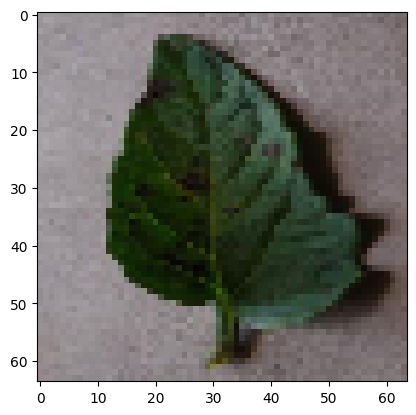

In [ ]:
imagepath = imread("/content/drive/MyDrive/plantdetection/Copy of 04ddbde3-d33c-42bf-b849-dad24d64fd6f___RS_Erly.B 7664.JPG")
image = imread("/content/drive/MyDrive/plantdetection/Copy of 04ddbde3-d33c-42bf-b849-dad24d64fd6f___RS_Erly.B 7664.JPG")
image = cv2.resize(image,(64,64))
imagepath = cv2.resize(imagepath,(64,64))
image = np.array(image/255)
image = image.reshape(-1,64,64,3)
plt.imshow(imagepath)

In [ ]:
classification_result = model.predict(image)
print(classification_result)

1/1 [==============================] - 0s 24ms/step
[[2.8180963e-07 3.7323055e-01 1.2759460e-07 6.6930918e-12 3.3638033e-31
  2.2340578e-17 4.5710874e-01 1.3528715e-02 1.5409614e-01 2.0266683e-03
  4.9445416e-16 6.4678586e-19 8.7417948e-06 1.1812662e-15 7.3609885e-18]]


In [ ]:
print(lb.classes_[(classification_result.argmax())])

Tomato_Early_blight


# Saving the Model

In [ ]:
model.save('vgg16')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("vgg16")
tflite_model = converter.convert()


with open("vgg16.tflite", "wb") as f:
    f.write(tflite_model)